<font size="8">Analysis of the Mental Health in the Tech Industry Dataset</font>

# Introduction

In this project a SQLite database from the Kaggle (https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry) will be used.
This data is from Open Source Mental Illness (OSMI) using survey data from years 2014, 2016, 2017, 2018 and 2019. Each survey measures and attitudes towards mental health and frequency of mental health disorders in the tech workplace.

To get a better feel of data and find useful patterns, the queries and filtering data using SQLite, Pandas, visualizing data with Matplotlib & Seaborn will be performed.

The scope of this project includes:
* Purpose of the exploratory data analysis
* Data loading using SQLite and Pandas
* Data Cleaning and Preprocessing
* Exploratory data analysis
* Utility functions creation and Data visualization
* Key Findings and Insights
* Conclusion

# Purpose of the Exploratory Data Analysis

Based on the provided survey data from Open Source Mental Illness (OSMI) and during the analysis obtained insights, the purpose of this Exploratory Data Analysis is to learn more about the persons who participated in this survey and their personal characteristics. Moreover, to make recommendations, so that the results of the next organized surveys would be more objective and more reflective of a larger group of people working in this field.

## Objectives of the EDA

The objectives of this exploratory data analysis are as follows:

* Identify the people who participated in the survey and classify them according to their age, gender and their work position;
* Determine the trend of groups by age, gender and work position distribution among the people participating in the survey over the years;
* Determine which group of people gives the longest answers to open-ended questions, which ones give the shortest answers;
* Evaluate the relationship between the length of the given answer and the group to which the respondent is assigned;
* Summarize the findings and make recommendations based on them.

# Data loading using SQLite and Pandas

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


from utils import (
    plot_hist_distribution,
    plot_boxplot_distribution,
    plot_area_stacked,
    plot_barplot_distribution_by_year,
    plot_percentage_bar_chart,
    plot_average_answer_length,
    plot_correlation_heatmap,
    plot_hexbin_scatter
)

Based on the information provided by the author, the database contains 3 tables : Survey, Question, and Answer.

In this project, the main focus will be on answers related to the interviewed person's age, gender, work position, as well as unrestricted responses in their own words to open questions. Therefore, related keywords will be chosen and used in SQL queries accordingly.

## Selection of questions for analysis

In this subsection, questions with related answers will be selected for further analysis. The following keywords will be used when identifying relevant questions:
* age;
* gender;
* position;
* describe.

In [2]:
db_connection = sqlite3.connect('./mental_health.sqlite') 

First, all the questions that contain the word __"age"__ is loaded, in order to determine whether there is such a question and, if so, to identify the question id number.

In [3]:
age_survey_questions = pd.read_sql(
    'SELECT DISTINCT questiontext, questionid '
    'FROM question '
    'WHERE questiontext LIKE "%age%";',
    db_connection
)

In [4]:
pd.set_option('display.max_colwidth', None)
age_survey_questions

,questiontext,questionid
0,What is your age?,1
1,Does your employer provide mental health benefits as part of healthcare coverage?,10
2,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,11
3,Do you know the options for mental health care available under your employer-provided health coverage?,14
4,Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?,20
5,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,27
6,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",55


On the same principle, all the questions that contain the word __"gender"__ is loaded. To determine whether there is such a question and, if so, to identify the question id number.

In [5]:
gender_survey_questions = pd.read_sql(
    'SELECT DISTINCT questiontext, questionid '
    'FROM question '
    'WHERE questiontext LIKE "%gender%";',
    db_connection
)

In [6]:
gender_survey_questions

,questiontext,questionid
0,What is your gender?,2


All the questions that contain the word __"position"__ is loaded to determine whether there is such a question and, if so, to identify the question id number.

In [7]:
position_survey_questions = pd.read_sql(
    'SELECT DISTINCT questiontext, questionid '
    'FROM question '
    'WHERE questiontext LIKE "%position%";',
    db_connection
)

In [8]:
position_survey_questions

,questiontext,questionid
0,Which of the following best describes your work position?,117


All the questions that contain the word __"describe"__ is loaded in order to determine whether there is such a question and, if so, to identify the question id number.

In [9]:
open_answer_survey_questions = pd.read_sql(
    'SELECT DISTINCT questiontext, questionid '
    'FROM question '
    'WHERE questiontext LIKE "%describe%";',
    db_connection
)

In [10]:
open_answer_survey_questions

,questiontext,questionid
0,"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",59
1,Describe the conversation with coworkers you had about your mental health including their reactions.,61
2,Describe the conversation your coworker had with you about their mental health (please do not use names).,63
3,"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",71
4,Describe the conversation you had with your previous coworkers about your mental health including their reactions.,73
5,Describe the conversation your coworker had with you about their mental health (please do not use names)..1,75
6,Describe the circumstances of the badly handled or unsupportive response.,82
7,Describe the circumstances of the supportive or well handled response.,84
8,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,86
9,Which of the following best describes your work position?,117


Since there was found not many related questions, relevant questions can be maually selected for further analysis. For further work with them, the question identification numbers will be stored seperatly.

It is important to keep in mind that in the further SQL queries, these question id numbers will be used to filter data by using WHERE and IN clauses and IN clause expects a comma-separated list. For this reason, the id numbers are stored as a strings.

In [11]:
age_related_question_id = '1'
gender_related_question_id = '2'
position_related_question_id = '117'
open_answer_related_question_id = '59, 61, 63, 71, 73, 75, 82, 84, 86'

## Data loading

To evaluate the answers to the selected questions, the data is loaded into dataframes. After the initial evaluation, the queries will be adjusted in the next subsection if needed.

The "__df_age__" data set will contain answers to the selected question related to age of the person participating in the survey.

In [12]:
df_age = pd.read_sql(
    'SELECT a.userid, q.questiontext, a.answertext, a.surveyid '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({age_related_question_id});',
    db_connection
)

The "__df_gender__" data set will contain answers to the selected question related to gender of the person participating in the survey.

In [13]:
df_gender = pd.read_sql(
    'SELECT a.userid, q.questiontext, a.answertext, a.surveyid '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({gender_related_question_id});',
    db_connection
)

The "__df_position__" data set will contain answers to the selected question related to work position of the person participating in the survey.

In [14]:
df_position = pd.read_sql(
    'SELECT a.userid, q.questiontext, a.answertext, a.surveyid '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({position_related_question_id});',
    db_connection
)

The "__df_answer_lenght__" data set will contain unrestricted responses in own words to open questions of persons participating in the survey. Also a new feature has also been added, which indicates the number of symbols in the answer.

In [15]:
df_answer_length = pd.read_sql(
    'SELECT a.userid respondent_id, q.questiontext, a.answertext, LENGTH(a.answertext) AS answer_lenght, a.surveyid '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({open_answer_related_question_id});',
    db_connection
) 

# Data Cleaning and Preprocessing

In this section, the answers to the selected questions will be evaluated, their suitability for use in further analysis will be checked and to avoid distortion of the analysis results - data selection decisions will be made.

## Age of the survey respondent

The fastest way to evaluate whether the collected data is logical is to look at the descriptive statistics summary and the first thing that must be done is to ensure that the values representing age values are appropriate data type.

In [16]:
df_age['AnswerText'] = df_age['AnswerText'].astype(int)
df_age['AnswerText'].describe()

count    4218.000000
mean       33.915363
std        10.478054
min       -29.000000
25%        28.000000
50%        33.000000
75%        38.000000
max       329.000000
Name: AnswerText, dtype: float64

From the descriptive statistics it can be seen that logically it is not possible to explain the age of the youngest person and the oldest, so it is assumed that someone refused to enter the real age by entering obviously illogical values.

So that such cases do not distort the results of the planned analysis, data falling within the following reasonable limits will be used for further data analysis:
* The minimum age must not be less than 14;
* The maximum age must not be higher than 90.

In [17]:
df_age = pd.read_sql(
    'SELECT a.userid respondent_id, CAST(a.answertext AS INTEGER) age, a.surveyid years_of_survey '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({age_related_question_id}) '
    'AND CAST(a.answertext AS INTEGER) BETWEEN 16 AND 90;',
    db_connection
)

## Gender of the survey respondent

Since it was possible to name the gender in a free form, before deciding whether it is necessary and, if so, in which forms to group the answers, first it would be fair to review the most popular answers.

In [18]:
gender_value_counts = df_gender['AnswerText'].value_counts()
print(f'A total of {df_gender.shape[0]} people answered the question and '
      f'of which {df_gender["AnswerText"].nunique()} are unique.\n\n'
      f'Based on the frequency of repetition, the answers are :\n\n{gender_value_counts}')

A total of 4218 people answered the question and of which 101 are unique.

Based on the frequency of repetition, the answers are :

AnswerText
Male                           2830
Female                          914
male                            212
female                          110
-1                               24
                               ... 
I have a penis                    1
I am a Wookie                     1
Human                             1
Guy (-ish) ^_^                    1
uhhhhhhhhh fem genderqueer?       1
Name: count, Length: 101, dtype: int64


It can be seen that the first four places in terms of popularity are taken by answers indicating traditional genders. Without them there are quite a lot of unique answers as well, but in the absence of one (or more) extremely popular groups, these answers will be grouped together.

As mentioned before, answer values will be assigned to one of three groups based on gender:
1. __Female__ - this group will include people with the answer values __"female"__ or __"Female"__;
2. __Male__ - this group will include people with the answer values __"males"__ or __"Males"__;
3. __Other__ - this group will include people with answers which were not assigned to _Female_ or _Male_ groups.

_Note: To avoid possible inconsistencies due to capitalization, all answers will be evaluated as lowercase letters._

In [19]:
df_gender = pd.read_sql(
    'SELECT a.userid respondent_id,  '
    'CASE '
        'WHEN LOWER(a.answertext) LIKE "female" THEN "Female" '
        'WHEN LOWER(a.answertext) LIKE "male" THEN "Male" '
        'ELSE "Other" '
    'END AS gender_group, '
    'a.surveyid years_of_survey '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({gender_related_question_id});',
    db_connection
)

## Work position of survey respondent

From the question it self ("_Which of the following.._"), it can be seen that the answers could be chosen from the given options.

In [20]:
position_value_counts = df_position['AnswerText'].value_counts()
print(f'Based on the frequency of repetition, the answers are :\n\n{position_value_counts}')

Based on the frequency of repetition, the answers are :

AnswerText
Back-end Developer         737
Front-end Developer        502
DevOps/SysAdmin            282
Supervisor/Team Lead       277
Other                      187
Support                    168
One-person shop            161
Designer                   135
Executive Leadership       101
Dev Evangelist/Advocate     99
Sales                       31
HR                          12
Name: count, dtype: int64


Since all answers are as expected, no further action will be taken at this stage.

## Unrestricted responses in own words

Since the respondents could express their opinion in a free form in the answers, it would be difficult to evaluate the meaningfulness of the answers at this stage, therefore it was decided to focus on their uniqueness in order to evaluate the suitability of the answers for further analysis.

In [21]:
answer_length_value_counts = df_answer_length['AnswerText'].value_counts()
print(f'Based on the frequency of repetition, the answers are :\n\n{answer_length_value_counts.head()}')

Based on the frequency of repetition, the answers are :

AnswerText
-1               10277
.                   11
\n                  10
no                   9
Same as above        5
Name: count, dtype: int64


From the most popular answers it can be seen that the most common answer is "-1". Also from the first look, it can be noticed that there are some random symbol, which possibly indicate the absence of an answer more than the answer itself. For this reason, a certain minimum number (in this case __> 3__) of characters will be assumed to validate the answer for further analysis.

In [22]:
df_answer_length = pd.read_sql(
    'SELECT q.questiontext question, a.answertext answer, LENGTH(a.answertext) answer_length, a.surveyid years_of_survey '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({open_answer_related_question_id}) '
    'AND LENGTH(a.answertext) > 3',
    db_connection
)

# Exploratory data analysis

## General information about survey respondents

### Age of the respondents

In [23]:
unique_years_number = df_age['years_of_survey'].nunique()
unique_years_values = ', '.join(map(str, df_age['years_of_survey'].unique()))
print(f"Data about the age of the respondents were collected in {unique_years_number} "
      f"different periods of time: {unique_years_values}.")

Data about the age of the respondents were collected in 5 different periods of time: 2014, 2016, 2017, 2018, 2019.


For a better understanding of the distribution, first, a visual approach will be used. To visually explore the distribution of data during all survey years in total - a histogram graphical representation will be used.

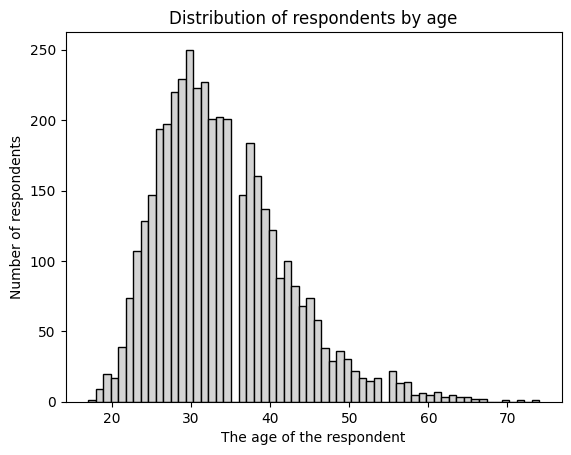

In [24]:
plot_hist_distribution(
    data_frame=df_age,
    column_name='age',
    bins=60,
    x_label='The age of the respondent',
    y_label='Number of respondents',
    title='Distribution of respondents by age'
)

Right-skewed distribution is noticed, which is going to cause mean to be greater than our median. To asses by how much and to asses the distribution of people who participated in the survey by age during all survey years in total, a summary of the descriptive statistics will be used.

In [25]:
df_age['age'].describe()

count    4203.000000
mean       33.855817
std         8.068257
min        17.000000
25%        28.000000
50%        33.000000
75%        38.000000
max        74.000000
Name: age, dtype: float64

To assess the distribution of participants by age and the year when the survey was conducted, a new dataframe is created by creating new columns according to the year of the survey.

In [26]:
df_age_by_year = pd.pivot_table(df_age, values='age', index='respondent_id', columns='years_of_survey')
df_age_by_year.describe()

years_of_survey,2014,2016,2017,2018,2019
count,1252.000000,1429.000000,754.000000,417.000000,351.000000
mean,32.083866,34.074178,34.988064,34.916067,35.595442
std,7.289722,8.096068,8.338051,8.047047,8.891819
min,18.000000,17.000000,18.000000,19.000000,19.000000
25%,27.000000,28.000000,29.000000,29.000000,29.000000
50%,31.000000,33.000000,34.000000,34.000000,34.000000
75%,36.000000,39.000000,40.000000,39.000000,41.000000
max,72.000000,74.000000,67.000000,67.000000,64.000000


Also to compare the distribution of data between surveys conducted in different years and to identifying outliers boxplot visual representation will be used.

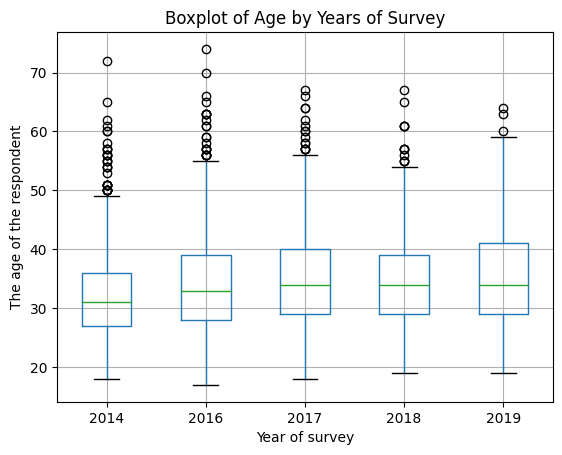

In [27]:
plot_boxplot_distribution(
    data_frame=df_age_by_year,
    x_label='Year of survey',
    y_label='The age of the respondent',
    title='Boxplot of Age by Years of Survey'
)

For an easier understanding of the age of the people who participated in the survey and how they changed in different survey years, the respondents will be divided into 6 age groups.
It will also be useful for further comparisons and possible relationships between other characteristics of the respondents.

In [28]:
df_age_groups = pd.read_sql(
    'SELECT '
    'a.surveyid years_of_survey, '
        'CASE WHEN (CAST(a.answertext AS INTEGER)) BETWEEN 16 AND 25 THEN "16-25" '
             'WHEN (CAST(a.answertext AS INTEGER)) BETWEEN 26 AND 35 THEN "26-35" '
             'WHEN (CAST(a.answertext AS INTEGER)) BETWEEN 36 AND 45 THEN "36-45" '
             'WHEN (CAST(a.answertext AS INTEGER)) BETWEEN 46 AND 56 THEN "46-55" '
             'WHEN (CAST(a.answertext AS INTEGER)) BETWEEN 56 AND 65 THEN "56-65" '
             'WHEN (CAST(a.answertext AS INTEGER)) >= 66 THEN "66+" '
        'END AS age_group, '
        'COUNT(*) AS count '
    'FROM answer a '
    'JOIN question q ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({age_related_question_id}) '
    'AND (CAST(a.answertext AS INTEGER)) BETWEEN 16 AND 90 '
    'GROUP BY a.surveyid, age_group;',
    db_connection
)

At the same time, it will be useful to see the total number of participants each year separately.

In [29]:
df_total_age_group = df_age_groups.groupby('years_of_survey')['count'].sum().reset_index()
df_total_age_group['age_group'] = 'total'
df_age_groups= pd.concat([df_age_groups, df_total_age_group], ignore_index=True)

In [30]:
df_age_groups_counts = (
    df_age_groups.groupby(['years_of_survey', 'age_group'])
    .size()
    .reset_index(name='count')
)
df_age_groups_counts = df_age_groups.pivot(
    index='age_group',
    columns='years_of_survey',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_age_groups_counts

years_of_survey,2014,2016,2017,2018,2019
age_group,,,,,
16-25,217,168,81,38,38
26-35,701,740,353,200,150
36-45,278,395,235,142,112
46-55,46,108,70,29,44
56-65,9,15,13,7,7
66+,1,3,2,1,0
total,1252,1429,754,417,351


The obtained data are also presented visually.

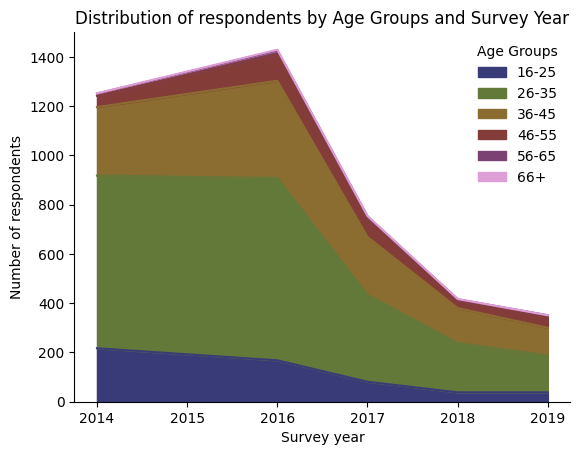

In [31]:
plot_area_stacked(
    data_frame=df_age_groups_counts,
    x_label='Survey year',
    y_label='Number of respondents',
    title='Distribution of respondents by Age Groups and Survey Year',
    legend_title='Age Groups'
)

From the graph above, it can be seen that the largest number of answers to the survey question was in 2016, and in the following years - the number of people who participated in the survey decreased significantly. The distribution of the respondents who participated in the survey by age groups can be seen in the following charts for each survey year seperatly.

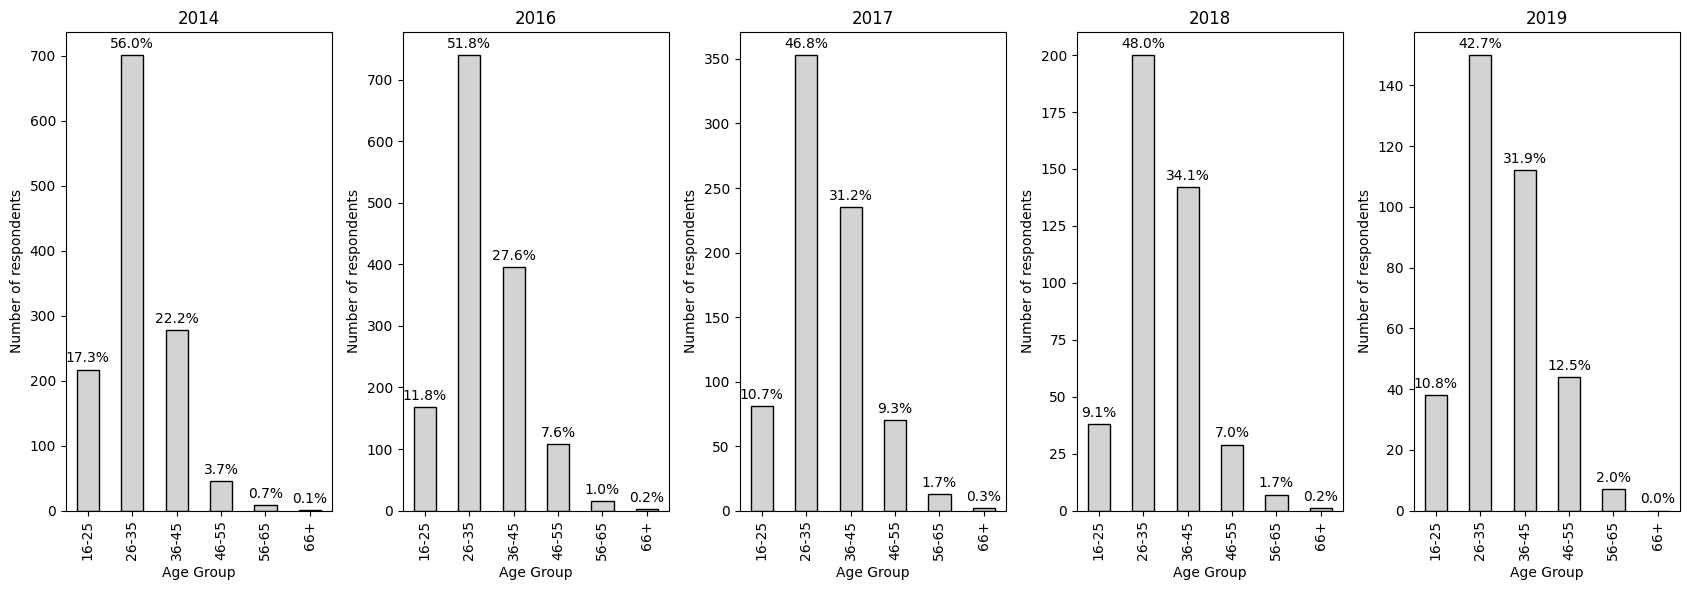

In [32]:
plot_barplot_distribution_by_year(
    data_frame=df_age_groups_counts,
    x_label='Age Group',
    y_label='Number of respondents'
)

### Gender of respondents

As it was mention before, the respondents are assigned into 3 gender groups. For an easier understanding the distribution of gender of the people who participated in the survey and how they changed in different survey years, information is presented below in numerical values and supplemented with visualizations.

In [33]:
df_gender_groups = pd.read_sql(
    'SELECT '
    'a.surveyid years_of_survey, '
        'CASE WHEN LOWER(a.answertext) LIKE "female" THEN "Female" '
             'WHEN LOWER(a.answertext) LIKE "male" THEN "Male" '
             'ELSE "Other" '
        'END AS gender_group, '
        'COUNT(*) AS count '
    'FROM answer a '
    'JOIN question q ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({gender_related_question_id}) '
    'GROUP BY a.surveyid, gender_group;',
    db_connection
)

In [34]:
df_total_gender_group = df_gender_groups.groupby('years_of_survey')['count'].sum().reset_index()
df_total_gender_group['gender_group'] = 'total'
df_gender_groups = pd.concat([df_gender_groups, df_total_gender_group], ignore_index=True)

In [35]:
df_gender_groups_counts = df_gender_groups.groupby(['years_of_survey', 'gender_group']).size().reset_index(name='count')
df_gender_groups_counts = df_gender_groups.pivot(
    index='gender_group',
    columns='years_of_survey',
    values='count'
).astype(pd.Int64Dtype()).fillna(0)

df_gender_groups_counts

years_of_survey,2014,2016,2017,2018,2019
gender_group,,,,,
Female,247,336,218,125,98
Male,991,1057,502,266,227
Other,22,40,36,26,27
total,1260,1433,756,417,352


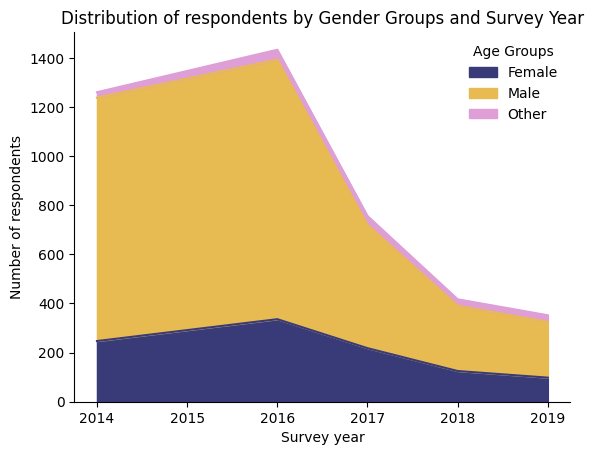

In [36]:
plot_area_stacked(
    data_frame=df_gender_groups_counts,
    x_label='Survey year',
    y_label='Number of respondents',
    title='Distribution of respondents by Gender Groups and Survey Year',
    legend_title='Age Groups'
)

From the graph above, it can be seen that the largest number of answers to the survey question was in 2016, and in the following years - the number of people who participated in the survey decreased significantly. The distribution of the respondents who participated in the survey by gender groups can be seen in the following charts for each survey year seperatly.

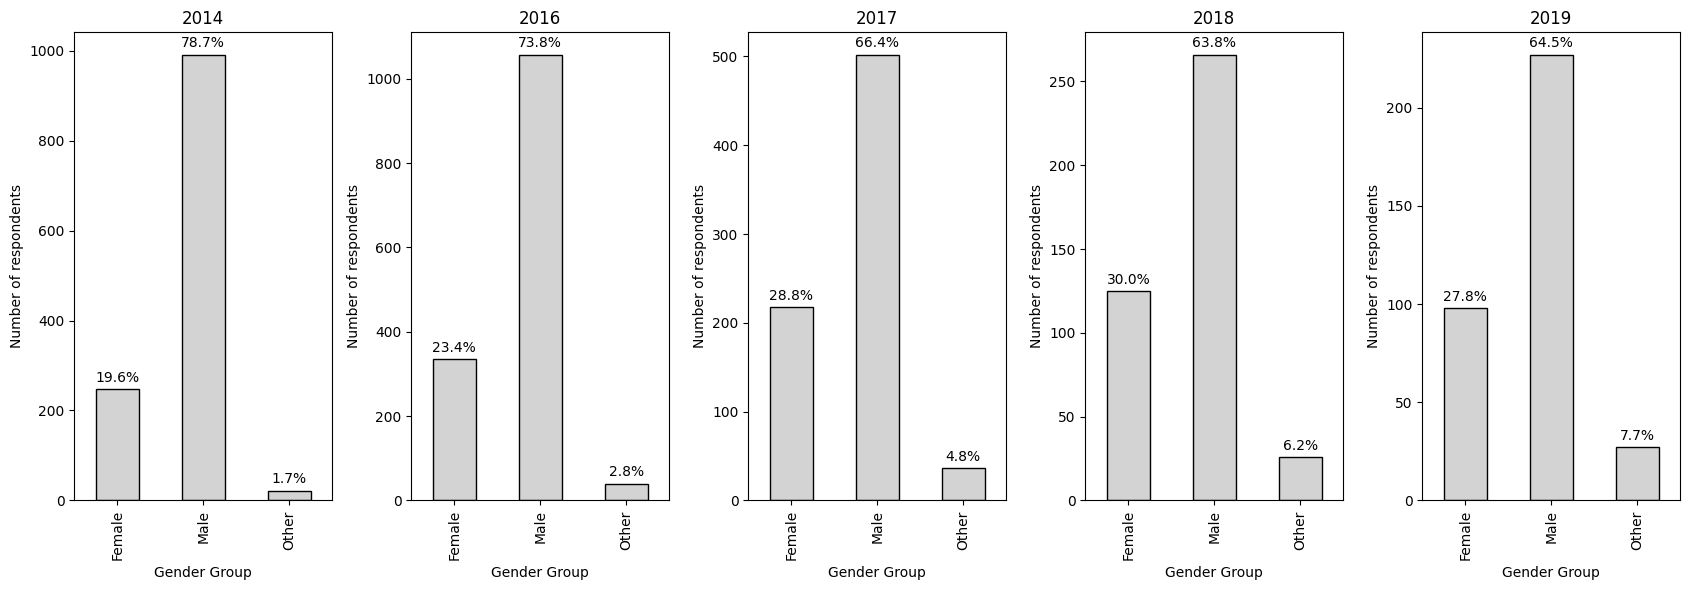

In [37]:
plot_barplot_distribution_by_year(
    data_frame=df_gender_groups_counts,
    x_label='Gender Group',
    y_label='Number of respondents'
)

### Work position of respondents

As it was respondents groups by age and gender, respondent groups by work profession will be explored as well by the same principles as before.

In [38]:
df_position_groups = pd.read_sql(
    'SELECT a.surveyid years_of_survey, a.answertext work_position, COUNT(*) AS count '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '
    f'WHERE q.questionid IN ({position_related_question_id}) '
    'GROUP BY a.surveyid, a.answertext;',
    db_connection
)

In [39]:
df_position_groups_counts = df_position_groups.groupby(['years_of_survey', 'work_position']).size().reset_index(name='count')
df_position_groups_counts = df_position_groups.pivot(
    index='work_position',
    columns='years_of_survey',
    values='count'
).astype(int)

df_position_groups_counts

years_of_survey,2016
work_position,
Back-end Developer,737
Designer,135
Dev Evangelist/Advocate,99
DevOps/SysAdmin,282
Executive Leadership,101
Front-end Developer,502
HR,12
One-person shop,161
Other,187


From the data set above, it can be seen that the data on the work position is collected only for those who participated in 2016. The distribution of the respondents who participated in the survey by work position groups can be seen in the following chart.

In [40]:
print('The total number of persons who entered the information '
      f'about work position is {df_position_groups_counts[2016].values.sum()}.')

The total number of persons who entered the information about work position is 2692.


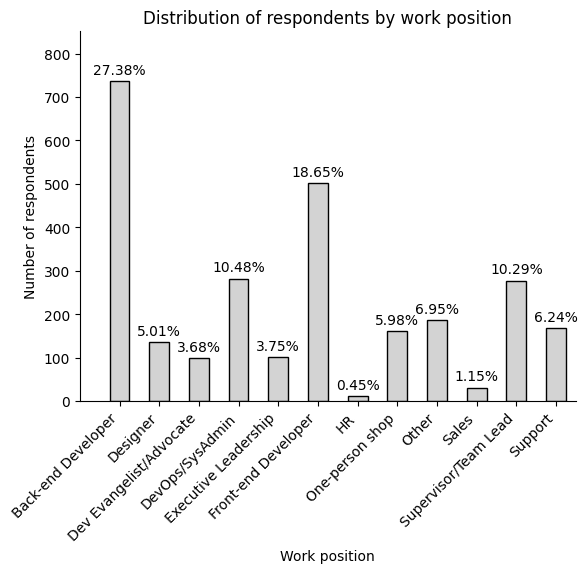

In [53]:
plot_percentage_bar_chart(
    data_frame=df_position_groups_counts,
    x_label='Work position',
    y_label='Number of respondents',
    title='Distribution of respondents by work position'
)

## Questions that are answered in a free form

In this section, the length of the answer (number of symbols in the answer) will be evaluated according to which group the respondent is assigned to. Exploration will be performed based on the groups which was used in the previous analyzies (by to their age and gender).

__NOTE__: only the data of respondents who provided answers according to the requirements set for them in terms of age, gender and job position will be used for the analysis.

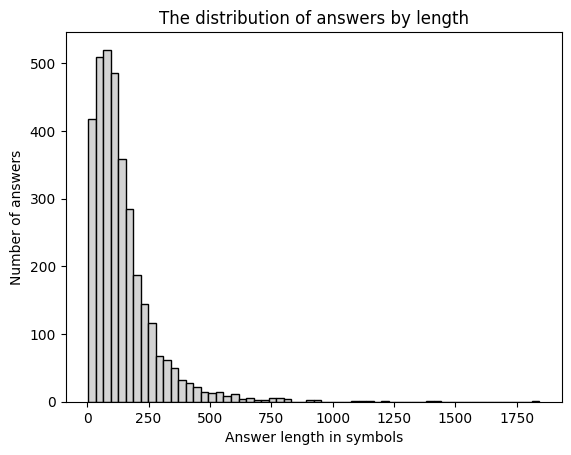

In [42]:
plot_hist_distribution(
    data_frame=df_answer_length,
    column_name='answer_length',
    bins=60,
    x_label='Answer length in symbols',
    y_label='Number of answers',
    title='The distribution of answers by length'
)

Right-skewed distribution is noticed, which is going to cause mean to be greater than our median. To asses by how much and to find out more about the distribution a summary of the descriptive statistics will be used.

In [43]:
df_answer_length['answer_length'].describe()

count    3388.000000
mean      144.651122
std       135.273978
min         4.000000
25%        60.000000
50%       111.000000
75%       183.000000
max      1842.000000
Name: answer_length, dtype: float64

### The length of the answer differences based on the respondent's gender

A new dataset will be created for this analysis, with the additional condition that the respondent must have answers to all questions relevant to this project.

In [44]:
print(f'Since data with open questions are only from years {", ".join(map(str, df_answer_length["years_of_survey"].unique()))} '
      'and data related to work positions is only from 2016, '
      'the relation between these features will not be investigated.')

Since data with open questions are only from years 2018, 2017, 2019 and data related to work positions is only from 2016, the relation between these features will not be investigated.


In [45]:
length_by_gender = pd.read_sql(
    'SELECT a.userid respondent_id, l.answer_length, '
    'CASE '
        'WHEN LOWER(a.answertext) LIKE "female" THEN "Female" '
        'WHEN LOWER(a.answertext) LIKE "male" THEN "Male" '
        'ELSE "Other" '
    'END AS gender_group, '
    'a.surveyid years_of_survey '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '

    f'JOIN ( '
        'SELECT a.userid, q.questiontext question, a.answertext answer, LENGTH(a.answertext) answer_length, a.surveyid years_of_survey '
        'FROM question q '
        'JOIN answer a ON q.questionid = a.questionid '
        f'WHERE q.questionid IN ({open_answer_related_question_id}) '
        'AND LENGTH(a.answertext) > 3) l ON a.userid = l.userid '

    f'WHERE q.questionid IN ({gender_related_question_id});',
    db_connection
)

To evaluate the variation of the average response length in different years survey, in the next step the new dataset will be transformed.

In [46]:
df_length_by_gender = length_by_gender.pivot_table(index='years_of_survey', columns='gender_group', values='answer_length', aggfunc='mean')
df_length_by_gender

gender_group,Female,Male,Other
years_of_survey,,,
2017,155.915730,125.776680,164.736842
2018,181.158774,145.013752,144.577778
2019,174.576512,125.636538,139.846154


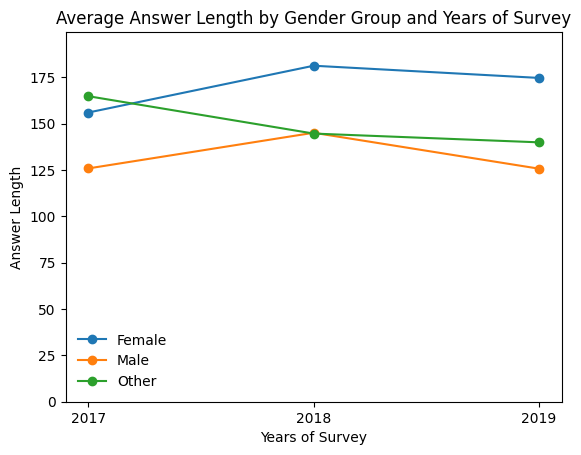

In [47]:
plot_average_answer_length(
    data_frame=df_length_by_gender,
    x_label='Years of Survey',
    y_label='Answer Length',
    title='Average Answer Length by Gender Group and Years of Survey'
)

From the obtained data, it can be seen that men used fewer (by about 20%) symbols than women when answering the same questions throughout the survey.

### The length of the answer differences based on the respondent's age

In this section it will be assessed whether there is a relationship between respondent age and length of the entered answer.
To compute pairwise correlation of features, a __Pearson__ (standard correlation coefficient, which is measured of linear correlation between two sets of data) method will be used.

In [48]:
len_by_age= pd.read_sql(
    'SELECT CAST(a.answertext AS INTEGER) age, a.surveyid years_of_survey, l.answer_length '
    'FROM question q '
    'JOIN answer a ON q.questionid = a.questionid '

    f'JOIN ( '
        'SELECT a.userid, q.questiontext question, a.answertext answer, LENGTH(a.answertext) answer_length, a.surveyid years_of_survey '
        'FROM question q '
        'JOIN answer a ON q.questionid = a.questionid '
        f'WHERE q.questionid IN ({open_answer_related_question_id}) '
        'AND LENGTH(a.answertext) > 3) l ON a.userid = l.userid '

    
    f'WHERE q.questionid IN ({age_related_question_id}) '
    'AND CAST(a.answertext AS INTEGER) BETWEEN 16 AND 90;',
    db_connection
)

In [49]:
corr_len_by_age = len_by_age.corr()
corr_len_by_age

,age,years_of_survey,answer_length
age,1.00000,0.030150,-0.085800
years_of_survey,0.03015,1.000000,0.025288
answer_length,-0.08580,0.025288,1.000000


corr_len_by_age

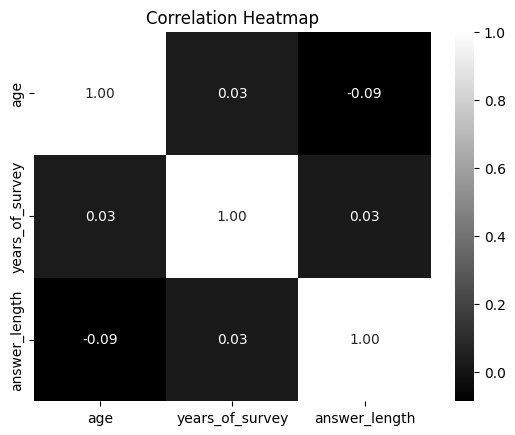

In [50]:
plot_correlation_heatmap(corr_len_by_age)

From the correliation heatmap it can be seen, that there is almost no correlation between respondent age and the length of answer. Despite this, an attempt will be made to visualize the available data in another way, perhaps the dependence is non-linear kind.

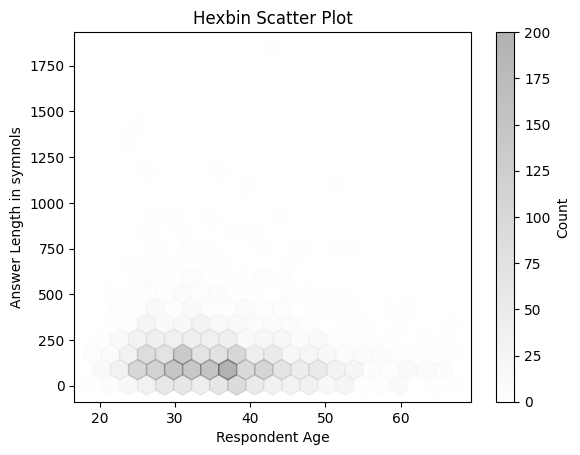

In [51]:
plot_hexbin_scatter(
    x_data=len_by_age['age'],
    y_data=len_by_age['answer_length'],
    x_label='Respondent Age',
    y_label='Answer Length in symnols',
    title='Hexbin Scatter Plot'
)

Unfortunately, the used visualization method did not help to find out the direct relationship between the age of the respondent and the length of the answer given by him.

# Key Findings and Insights

Summarizing of the knowledge and insights gained during the analysis of collected data from Open Source Mental Illness (OSMI) is as follows:
* Although the survey has been conducted for 5 years, the number of persons participating in the survey for the last 3 consecutive years has been decreased;
* Although the number of participants in the survey is decreasing significantly, such a drastic change in the distribution of respondents by age was not observed;
* Although according to the data more and more women participated in the survey, men still make up the majority of respondents;
* During the analysis it was found that women tend to give longer answers to open questions;
* No proof was found to assert that there is a relationship between the length of the answer and the age of the respondent.


# Conclusion

After evaluating those who took part in the survey in terms of their age, gender, positions held, it was noticed that the respondents of the groups are unevenly distributed. For this reason, evaluating the answers according to their content, the results of the analysis could reflect only some group of people more than the general state of emotional health in the tech industry.

When organizing the survey in the future, it is recommended to provide possible answers to questions related to which specific demographic group, a geographical region, or any other defined group so the answers would represent a larger population.